# 2DO EXAMEN PARCIAL

ESTUDIANTE: Miranda Veniz Marcela

DATASET D1: https://www.kaggle.com/datasets/mariyamalshatta/inn-hotels-group

# *Grupo de Hoteles INN*
Las cancelaciones de reservas de hotel (especialmente de última hora) generan pérdidas de ingresos, costos adicionales de reventa y esfuerzo operativo. Con los canales de reserva online, este problema se ha acentuado: los clientes pueden cambiar planes fácilmente y los hoteles necesitan anticiparse para minimizar el impacto.

Objetivo
Construir un modelo de machine learning que, basado en los detalles de cada reserva (huespedes, fechas, tipo de habitación, plan de comidas, historial de cancelaciones, etc.), prediga la probabilidad de cancelación y ayude a definir políticas de tarifas y reembolsos más rentables.

Descripción condensada de los datos

Booking_ID: identificador único.

Atributos del huésped y la estancia: número de adultos/niños, noches de fin de semana/entre semana, plan de comidas, necesidad de parking, tipo de habitación.

Fechas: lead_time (días hasta la llegada), año/mes/día de llegada.

Historial y segmento: si es huésped repetido, número de cancelaciones y reservas previas, segmento de mercado.

Precio y solicitudes: precio medio por noche y número de peticiones especiales.

booking_status: etiqueta objetivo (0 = no cancelada, 1 = cancelada).

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
from matplotlib.ticker import FixedLocator, FixedFormatter

# Cargamos el dataset

In [23]:
data = pd.read_csv('/content/drive/MyDrive/2doParcial/INNHotelsGroup.csv')

data

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


## Preprocesamiento del dataset

Aplicamos One hot Encoding en nuestras varibles teoricas
Normalizamos las variables numericas

Cargamos todos los datos a nuestra variable X. Eliminando columnas inecesarias como ser "Booking_ID" que es el identificador único de reserva, no tiene poder predictivo. "booking_status" la etiqueta que pasa a y


In [24]:
X = data.drop(['Booking_ID','booking_status'], axis=1)

Codificamos la columna "booking_status" a 0 y 1 ya que solo tiene 2 etiquetas

0:Not_Canceled;       1:Canceled;

In [25]:
y = data['booking_status'].map({'Not_Canceled':0,'Canceled':1})

Aplicamos ONE HOT ENCODING a todas nuestras variable cualitativas que listamos de manera manual

In [26]:
categorical_cols = ['type_of_meal_plan','room_type_reserved','market_segment_type']

todas las demás columnas de X, obtenidas por comprensión de lista. Estas se tratan como cuantitativas y se escalan.

In [27]:
numeric_cols = [c for c in X.columns if c not in categorical_cols]

Pipeline de preprocesado: aplica transformaciones diferentes a grupos de columnas:

num: escalado de las columnas numéricas para que queden con media = 0 y desviación estándar = 1, lo cual facilita la convergencia de muchos modelos.

cat: aplicación de OneHotEncoder para convertir cada categoría en un vector binario, produciendo un arreglo denso y evitando errores si aparecen categorías desconocidas en el conjunto de test.

In [28]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),
])

X_proc = preprocessor.fit_transform(X)
print("Matriz X_proc:", X_proc.shape)

Matriz X_proc: (36275, 30)


Separamos un 20% de los datos para validacion

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, stratify=y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (29020, 30) Test: (7255, 30)


# Encontrar k óptimo con Silhouette Score
Probamos k de 2 a 15 y graficamos el resultado.


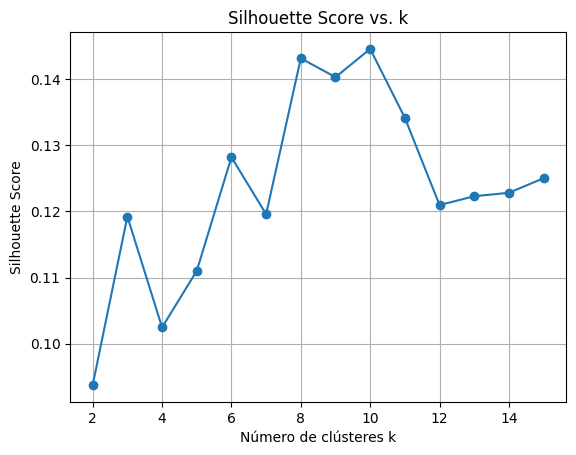

🔹 Mejor k según Silhouette Score: 10


In [30]:
sil_scores = []
k_range = range(2, 16)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42).fit(X_train)
    sil_scores.append(silhouette_score(X_train, km.labels_))

plt.plot(k_range, sil_scores, 'o-')
plt.title('Silhouette Score vs. k')
plt.xlabel('Número de clústeres k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

best_k = k_range[int(np.argmax(sil_scores))]
print(f"🔹 Mejor k según Silhouette Score: {best_k}")


Esta función visualiza el coeficiente de Silhouette para cada punto dentro de los clústeres para diferentes valores de k (de 2 a 15).

In [31]:
def visualizar_silhouettes(X, max_k=15, random_state=42):
    ks = range(2, max_k+1)
    n_plots = max_k - 1
    n_cols  = 3
    n_rows  = (n_plots + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axs = axs.flatten()

    for idx, k in enumerate(ks):
        km = KMeans(n_clusters=k, random_state=random_state)
        labels = km.fit_predict(X)
        sil_vals = silhouette_samples(X, labels)
        avg_score = silhouette_score(X, labels)

        y_lower = 10
        ax = axs[idx]
        for i in range(k):
            coeffs = np.sort(sil_vals[labels == i])
            size_cluster = coeffs.shape[0]
            y_upper = y_lower + size_cluster
            color = cm.nipy_spectral(i / k)

            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, coeffs,
                             facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
            y_lower = y_upper + 10

        ax.axvline(x=avg_score, color="red", linestyle="--")

        ax.set_title(f"k = {k} | Silhouette Avg = {avg_score:.2f}")
        ax.set_xlim(-0.1, 1)
        ax.set_yticks([])
        ax.set_xlabel("Coeficiente de silueta")

    for j in range(n_plots, len(axs.flat)):
        fig.delaxes(axs.flat[j])

    fig.suptitle("Visualización de Silhouette por Clusters", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


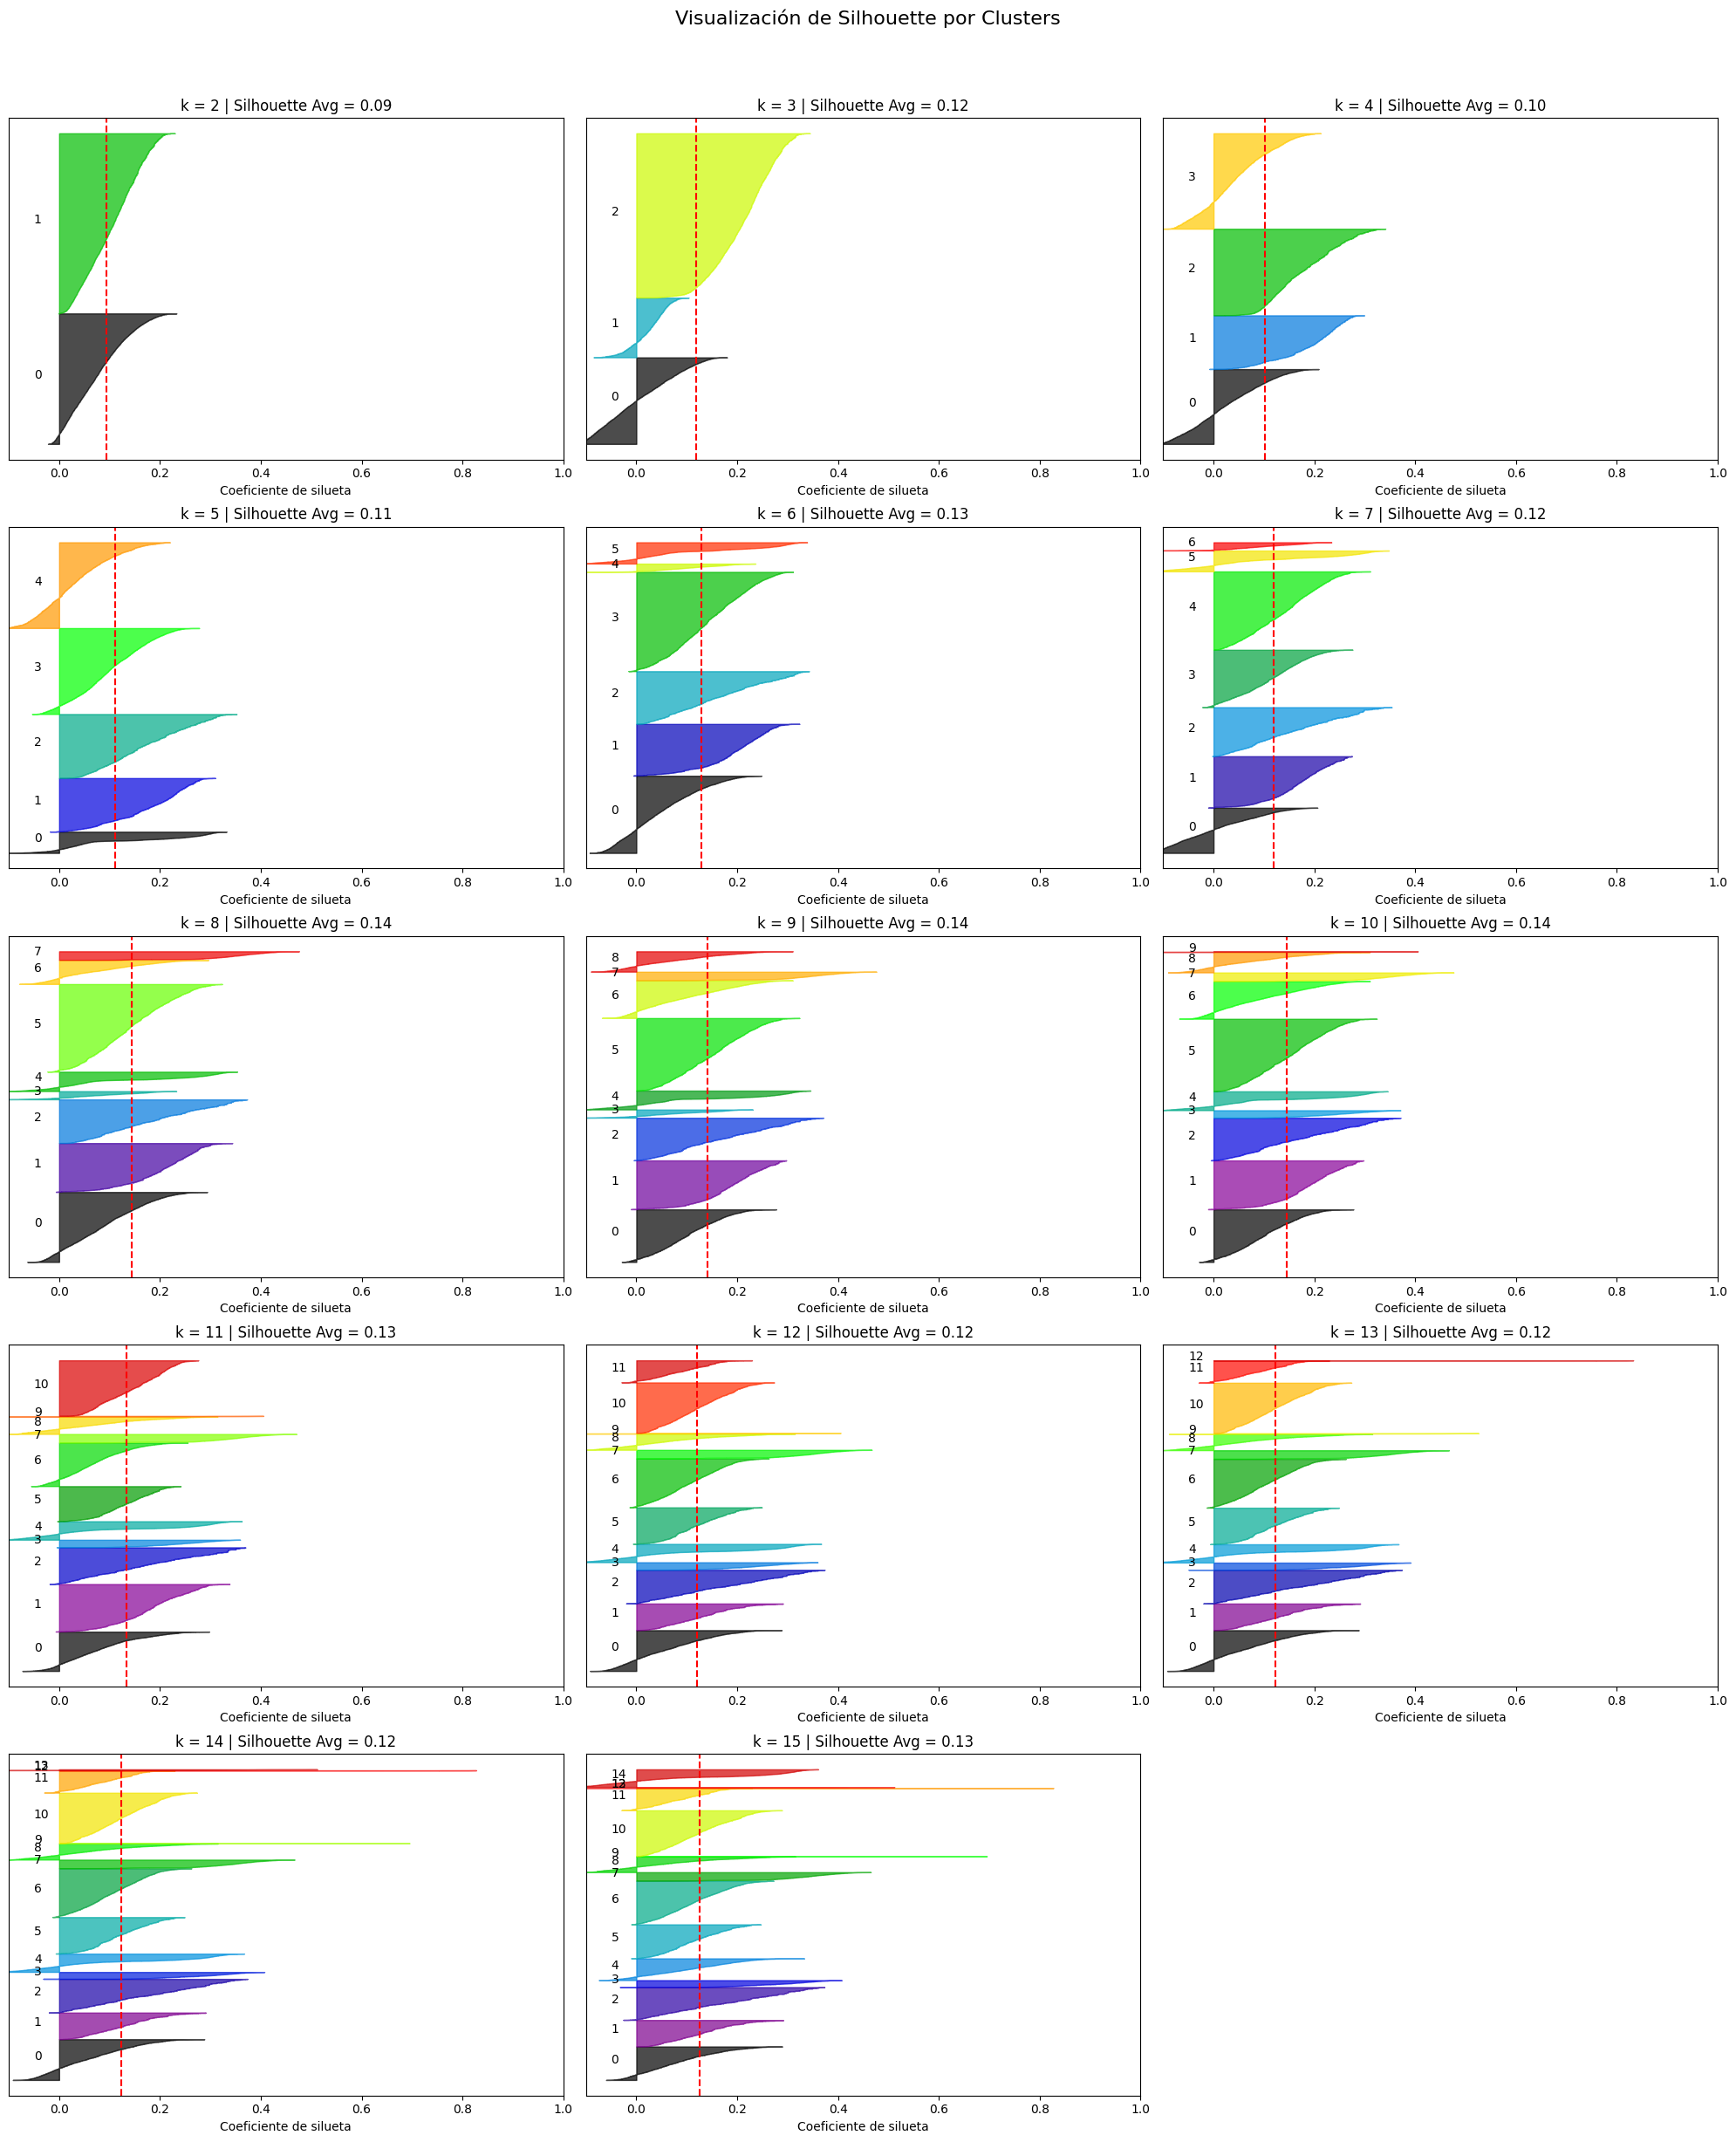

In [32]:
visualizar_silhouettes(X_train, max_k=15, random_state=42)

# kmeans
Se aplica el algoritmo K-Means para agrupar las imágenes con el k optimo obtenido en el silluete score.

In [33]:
k=best_k
kmeans = KMeans(n_clusters=k, random_state=42)
#ÍNDICES de las muestras más cercanas a cada centroide
X_digits_dist = kmeans.fit_transform(X_train)
labels = kmeans.fit_predict(X_train)  # etiquetas de los grupos
print("Primeras 10 etiquetas asignadas por KMeans:")
print(labels[:10])

Primeras 10 etiquetas asignadas por KMeans:
[0 1 8 0 2 0 4 5 5 1]


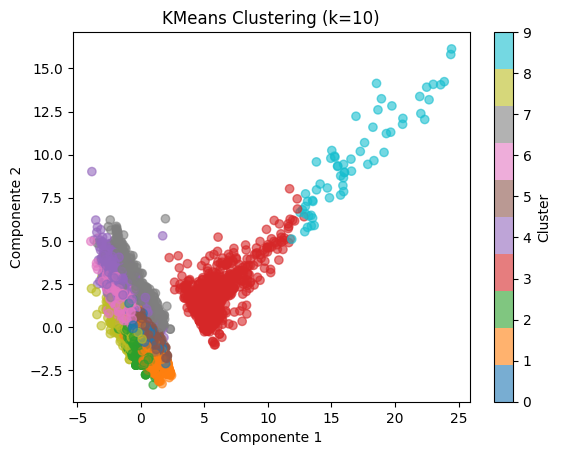

In [36]:
#Visualizar con PCA
from sklearn.decomposition import PCA
X_vis = PCA(n_components=2).fit_transform(X_train)

plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.title(f"KMeans Clustering (k={best_k})")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label="Cluster")
plt.show()

# APLICANDO APRENDISAJE SEMISUPERVISADO

Obteniendo el indice de los muestras mas representativos

In [37]:
idxs = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[idxs]
print("Índices representativos:", idxs)

Índices representativos: [ 5547  2867  5332  7247   862 21804  5878 21974 27083  1882]


Extraemos las etiquetas verdaderas de nuestras mustras mas representativas

In [38]:
y_representative_digits = y_train.values[idxs]

print("Etiquetas verdaderas de reps:", y_representative_digits)

Etiquetas verdaderas de reps: [0 0 1 0 0 0 0 0 0 0]


Entrenamos un modelo de regresión logística con solo los puntos representativos de cada cluster
Estos puntos son los más cercanos a cada centroide según KMeans

In [39]:
from sklearn.linear_model import LogisticRegression


log_reg2 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg2.fit(X_representative_digits, y_representative_digits)
log_reg2.score(X_test, y_test)

CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 20 ms


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7037904893177119

Entrenamos con los primeros 80 ejemplos reales del conjunto de entrenamiento

In [40]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg.fit(X_train[:80], y_train[:80])
log_reg.score(X_test, y_test)

CPU times: user 9.96 ms, sys: 0 ns, total: 9.96 ms
Wall time: 7.52 ms


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.8020675396278428

Creamos un vector con las mismas dimensiones que X_train
Propagamos la etiqueta del representante de cada cluster a todos los elementos de ese cluster

In [41]:
y_train_propagated = np.empty(len(X_train))
for i in range(k):
  y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

Entrenamos el modelo con las etiquetas propagadas

In [42]:
log_reg3 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg3.fit(X_train[:1000], y_train_propagated[:1000])
log_reg3.score(X_test, y_test)

CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 8.53 ms


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7484493452791179

# APRENDIZAJE ACTIVO

Obtenemos probabilidades de predicción del modelo
Ordenamos las instancias menos confiables (cercanas a 0.5) para seleccionarlas y etiquetarlas manualmente

In [43]:
probas = log_reg3.predict_proba(X_train[:1000])
labels_ixs = np.argmax(probas, axis=1)
labels = np.array([proba[ix] for proba, ix in zip(probas, labels_ixs)])
sorted_ixs = np.argsort(labels)
labels[sorted_ixs[:10]]

array([0.50030747, 0.5007396 , 0.51393154, 0.51717578, 0.52193408,
       0.52923823, 0.53496643, 0.53603289, 0.53603289, 0.53769521])

In [44]:
X_lowest = X_train[:1000][sorted_ixs[:k]]

Simulamos el etiquetado manual de las instancias menos confiables usamos las etiquetas verdaderas conocidas en y_train

In [45]:
y_lowest = y_train.values[:1000][sorted_ixs[:k]]
y_lowest

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1])

Actualizamos las etiquetas propagadas con estas verdaderas

In [46]:
y_train2 = y_train_propagated[:1000].copy()
y_train2[sorted_ixs[:k]] = y_lowest.flatten()

Entrenamos nuevamente el modelo con la corrección aplicada

In [47]:
log_reg5 = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
%time log_reg5.fit(X_train[:1000], y_train2)
log_reg5.score(X_test, y_test)

CPU times: user 12.5 ms, sys: 0 ns, total: 12.5 ms
Wall time: 8.88 ms


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7484493452791179

# MODELO DBSCAN

Matriz preprocesada: (36275, 30)
Número de clusters (sin contar ruido): 6
Etiquetas únicas (incluye -1 para ruido): [-1  0  1  2  3  4  5]


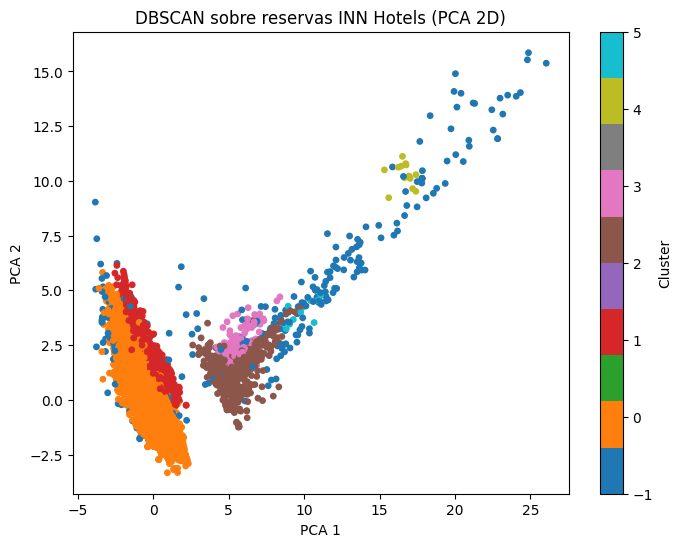

In [48]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Carga de datos
data = pd.read_csv('/content/drive/MyDrive/2doParcial/INNHotelsGroup.csv')

# Selección de variables para X
X = data.drop(['Booking_ID','booking_status'], axis=1)

# Columnas categóricas y numéricas
categorical_cols = ['type_of_meal_plan','room_type_reserved','market_segment_type']
numeric_cols     = [c for c in X.columns if c not in categorical_cols]

# Preprocesador: StandardScaler + OneHotEncoder
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),
])

X_proc = preprocessor.fit_transform(X)
print(f"Matriz preprocesada: {X_proc.shape}")

# Parámetros DBSCAN
eps = 3          # distancia máxima para vecinos
min_samples = 10    # mínimo de puntos para formar un cluster

dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels = dbscan.fit_predict(X_proc)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Número de clusters (sin contar ruido): {n_clusters}")
print(f"Etiquetas únicas (incluye -1 para ruido): {np.unique(labels)}")

# -Visualización en 2D con PCA
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_proc)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1],
                      c=labels, cmap='tab10', s=15)
plt.title("DBSCAN sobre reservas INN Hotels (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster")
plt.show()
